<a href="https://colab.research.google.com/github/saylieee/Codes/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
#https://github.com/soumith/ganhacks 

In [0]:
#!pip install keras numpy mnist

DCGAN is a Generative Adversarial Network (GAN) using CNN.
The generator tries to fool the discriminator by generating fake images.
The discriminator learns to discriminate real from fake images.
The generator + discriminator form an adversarial network.
DCGAN trains the discriminator and adversarial networks alternately.
During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the adversarial on how
to improve its ability to generate fake images.


In [0]:

import numpy as np
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

In [0]:
latent_dim = 100
img_rows, img_cols = 28, 28
img_channels = 1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255
final_img = ""

  Build a Generator Model to generate fake images
    Output activation is sigmoid
    Sigmoid converges easily.
    Returns:
        generator (Model): Generator Model
    

In [0]:
def generator_model(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    #model.summary()

    return model

Build a Discriminator Model
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.
    Returns:
        discriminator (Model): Discriminator Model

In [0]:
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [0]:
# build discriminator model
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0002, decay=6e-8), 
                      metrics=['accuracy'])

In [0]:
# build generator model
generator = generator_model()

In [0]:
# freeze the weights of discriminator during adversarial training
# original paper uses Adam, but discriminator converges easily with RMSprop
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=3e-8), 
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model

In [0]:
# build adversarial model
adversarial = adversarial_model()

In [0]:
im_list = []

Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid

In [0]:

def plot_images(saveArray, saveToFile=False, fake=True, samples=16, noise=None, epoch=0 ):    
    filename = 'mnist.png'

    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]
        
    if saveArray:
      im_list.append(images)
      
    #plt.figure(figsize=(100,100))

  #  for i in range(images.shape[0]):
   #     plt.subplot(32, 32, i+1)
    #    image = images[i, :, :, :]
     #   image = np.reshape(image, [img_rows, img_cols])
       # plt.imshow(image, cmap='gray')
       # plt.axis('off')
    
  #  plt.tight_layout()
   # if saveToFile:
        
    #    plt.savefig(filename)
     #   plt.close('all')
    #else:
     #   plt.show()"""


In [0]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  # plot loss
  plt.subplot(2, 1, 1)
  plt.plot(d1_hist, label='D-loss on real')
  plt.plot(d2_hist, label='D-loss on fake')
  plt.plot(g_hist, label='Gen loss')
  plt.title('model losses')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

  # plot discriminator accuracy
  plt.subplot(2, 1, 2)
  plt.plot(a1_hist, label='Disc-acc on real')
  plt.plot(a2_hist, label='Disc-acc on fake')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

	# save plot to file
  plt.savefig('Disc_Gen_acc_losses.png')
  plt.close()

# New Section

Train the Discriminator and Adversarial Networks
Alternately train Discriminator and Adversarial networks by batch.
Discriminator is trained first with properly real and fake images.
Adversarial is trained next with fake images pretending to be real
Generate sample images per save_interval.

In [0]:
## the generator image is saved every 100 steps
## noise vector to see how the generator output evolves during training
def train(train_epochs=5000, batch_size=256, save_interval=100): 
           
        noise_input = None
        saveArray = False
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])

        # prepare lists for storing stats each iteration
        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
 
        for epoch in range(train_epochs):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset

            # ---------------------
            #  Train Discriminator : select batch of real img, generate batch of fake img, 
            #label real as 1, fake as 0, train D on batch, calculate loss
            # ---------------------

            # number of elements in train dataset
            train_size = x_train.shape[0]
            
            # select a random half of images
            images_real = x_train[np.random.randint(0, train_size, size=batch_size), :, :, :]
            y_real = np.ones([batch_size, 1])

            d_loss1, d_acc1 = discriminator.train_on_batch(images_real, y_real)
            # sample noise and generate a batch of new images
            # generate fake images from noise using generator 
            # generate noise using uniform distribution
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            #print(noise.shape) 256*100

            # generate fake images
            images_fake = generator.predict(noise)
            #print(images_fake.shape) (256,28,28,1)"""
            
            # train the discriminator (real classified as ones and generated as zeros)
            # real + fake images = 1 batch of train data
            #x = np.concatenate((images_real, images_fake))
            # label real and fake images
            # real images label is 1.0
            y_fake = np.zeros([batch_size, 1])
            # fake images label is 0.0
            # train discriminator network, log the loss and accuracy
            d_loss2, d_acc2 = discriminator.train_on_batch(images_fake, y_fake)
            
            d_loss = 0.5 * np.add(d_loss1,d_loss2)

            # ---------------------
            #  Train Adversory Model
            # ---------------------
            
            # train the adversory (wants discriminator to mistake images as real)
            # train the adversarial network for 1 batch
            # 1 batch of fake images with label=1.0
            # since the discriminator weights are frozen in adversarial network
            # only the generator is trained

            # generate noise using uniform distribution
            #noise = np.random.uniform(-1.0,1.0, size=[batch_size, latent_dim])

            # label fake images as real or 1.0
            y = np.ones([batch_size, 1])

            #noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            # train the adversarial network 
            # note that unlike in discriminator training, 
            # we do not save the fake images in a variable
            # the fake images go to the discriminator input of the adversarial
            # for classification
            # log the loss and accuracy
           
            g_loss  = adversarial.train_on_batch(noise, y)
            
            # record history
            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
  
            log_msg = "%d: [Discriminator loss: %f, real acc: %f, fake acc: %f]" % (epoch, d_loss, d_acc1, d_acc2)
            log_msg = "%s  [Adverserial loss: %f, acc: %f]" % (log_msg, g_loss[0], g_loss[1])
            print(log_msg)


            if save_interval>0:
              if epoch+1==train_epochs:
                saveArray = True
                  # plot generator images on a periodic basis
              plot_images(saveArray, saveToFile=True, samples=noise_input.shape[0],noise=noise_input, epoch=(epoch)+1  )

        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

0: [Discriminator loss: 1.096598, real acc: 0.836914, fake acc: 0.000000]  [Adverserial loss: 0.741548, acc: 0.000000]
1: [Discriminator loss: 0.679591, real acc: 0.975586, fake acc: 0.500000]  [Adverserial loss: 0.754807, acc: 0.000000]
2: [Discriminator loss: 0.650400, real acc: 0.981445, fake acc: 1.000000]  [Adverserial loss: 0.764473, acc: 0.000000]
3: [Discriminator loss: 0.612535, real acc: 0.995117, fake acc: 1.000000]  [Adverserial loss: 0.750519, acc: 0.049805]
4: [Discriminator loss: 0.557720, real acc: 0.989258, fake acc: 1.000000]  [Adverserial loss: 0.655325, acc: 0.739258]
5: [Discriminator loss: 0.466238, real acc: 0.991211, fake acc: 1.000000]  [Adverserial loss: 0.409799, acc: 0.997070]
6: [Discriminator loss: 0.340561, real acc: 0.988281, fake acc: 1.000000]  [Adverserial loss: 0.159428, acc: 1.000000]
7: [Discriminator loss: 0.241098, real acc: 0.982422, fake acc: 1.000000]  [Adverserial loss: 0.053074, acc: 1.000000]
8: [Discriminator loss: 0.161000, real acc: 0.98

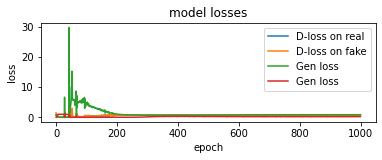

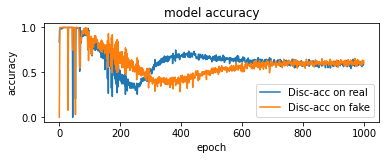

Elapsed: 9.20930567185084 min 


In [16]:
def main():
  #timer started
  timer = ElapsedTimer()
  train(train_epochs=2000, batch_size=1024, save_interval=10) 

  im_array =  np.array(im_list)
  im_array = np.reshape(im_array, (1024, 28, 28, 1))

  #print("final arr : ",im_array.shape)
  #print(im_array[0, :, :, :].shape)

  #pixels = im_array[0].reshape((28, 28))
  #plt.imshow(pixels, cmap='gray')
  #plt.show()

  #timer stopped
  timer.elapsed_time()

  #plot_images(fake=True)
  #plot_images(fake=False, saveToFile=True)

In [1]:
%sx read -p "enter epochs :"

['enter epochs :90']

In [0]:
def main():
 args = parser.parse_args(args=[])